# 02: 階層的クラスタリング (Hierarchical Clustering)

このノートブックでは、K-meansとは異なるアプローチをとるクラスタリング手法である「階層的クラスタリング」について学びます。
この手法は、データ間の類似度に基づいて、データを段階的にグループ化していき、最終的に樹形図（デンドログラム）で表現される階層的なクラスタ構造を構築します。

K-meansのように事前にクラスタ数 $K$ を指定する必要がなく、デンドログラムを分析することで、データに適したクラスタ数を事後的に判断できるのが大きな特徴です。

このノートブックでは、ボトムアップにクラスタを併合していく**凝集型**と、トップダウンにクラスタを分割していく**分割型**の2つのアプローチを学び、特に広く使われている凝集型クラスタリングをNumPyでスクラッチ実装します。

**参考論文:**
*   (Ward's method) Ward, J. H. (1963). Hierarchical Grouping to Optimize an Objective Function. *Journal of the American Statistical Association*, 58(301), 236-244.

**このノートブックで学ぶこと:**
1.  階層的クラスタリングの基本概念と、2つのアプローチ（凝集型・分割型）。
2.  凝集型クラスタリングのアルゴリズム。
3.  クラスタ間の距離（非類似度）を測る様々な手法（リンケージ法）：単連結、完全連結、群平均、ウォード法。
4.  ウォード法（Ward's method）の目的：クラスタ併合による分散の増加を最小化する。
5.  NumPyを用いた凝集型クラスタリング（ウォード法）のスクラッチ実装。
6.  結果を可視化するためのデンドログラムの作成と解釈。

**前提知識:**
*   ユークリッド距離の計算。
*   統計学の基礎知識（分散）。
*   NumPyによるベクトル・行列演算。
*   MatplotlibとSciPyによる可視化。

## 1. 必要なライブラリのインポート

今回は、デンドログラムの描画のために`scipy.cluster.hierarchy`を利用します。アルゴリズムの核心部分はNumPyで実装します。

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage

## 2. 階層的クラスタリングの理論

階層的クラスタリングは、データポイント間の類似度に基づき、入れ子構造（階層構造）のクラスタを構築します。主に2つのアプローチがあります。

### 2.1 凝集型 (Agglomerative) アプローチ

凝集型クラスタリングは「ボトムアップ」のアプローチです。

1.  **初期化**: 全てのデータポイントを、それぞれが独立した1つのクラスタとみなします（$N$個のクラスタからスタート）。
2.  **反復**:
    a.  全てのクラスタのペア間の**距離（非類似度）**を計算します。
    b.  最も距離が近い（最も似ている）2つのクラスタを**併合**して、1つの新しいクラスタを作ります。
    c.  クラスタの数が1になるまで、ステップ a, b を繰り返します。

この併合の過程を記録することで、階層的な構造が得られます。

### 2.2 分割型 (Divisive) アプローチ

分割型クラスタリングは「トップダウン」のアプローチです。

1.  **初期化**: 全てのデータポイントを、1つの巨大なクラスタとみなします。
2.  **反復**:
    a.  現在の各クラスタについて、どのように2つに分割すれば最も良い分割になるかを評価します。
    b.  最も適切に分割できるクラスタを選び、2つに分割します。
    c.  全てのデータポイントがそれぞれ独立したクラスタになるまで、ステップ a, b を繰り返します。

分割型は計算コストが非常に高いため、一般的には**凝集型**のアプローチが広く用いられます。このノートブックでも、凝集型に焦点を当てて解説と実装を行います。

## 3. クラスタ間の距離：リンケージ法

凝集型クラスタリングの核心は、「どのクラスタペアを併合するか」を決定するための**クラスタ間の距離**の定義です。この定義方法を**リンケージ法 (Linkage Method)** と呼びます。

クラスタ $A$ とクラスタ $B$ があるとき、その距離 $d(A, B)$ を計算する代表的な手法は以下の通りです。

*   **単連結法 (Single Linkage)**: 2つのクラスタ内のデータポイント間の全ての組み合わせの中で、**最も短い距離**をクラスタ間距離とします。
    $$ d(A, B) = \min_{\boldsymbol{x} \in A, \boldsymbol{y} \in B} ||\boldsymbol{x} - \boldsymbol{y}|| $$
*   **完全連結法 (Complete Linkage)**: 2つのクラスタ内のデータポイント間の全ての組み合わせの中で、**最も長い距離**をクラスタ間距離とします。
    $$ d(A, B) = \max_{\boldsymbol{x} \in A, \boldsymbol{y} \in B} ||\boldsymbol{x} - \boldsymbol{y}|| $$
*   **群平均法 (Average Linkage, UPGMA)**: 2つのクラスタ内のデータポイント間の全ての組み合わせの**距離の平均**をクラスタ間距離とします。
    $$ d(A, B) = \frac{1}{|A||B|} \sum_{\boldsymbol{x} \in A} \sum_{\boldsymbol{y} \in B} ||\boldsymbol{x} - \boldsymbol{y}|| $$
*   **ウォード法 (Ward's Method)**: 2つのクラスタを併合した際に、**クラスタ内平方和（WCSS）がどれだけ増加するか**をクラスタ間距離とします。この増加量が最小となるペアを併合します。
    $$ d(A, B) = \text{WCSS}(A \cup B) - (\text{WCSS}(A) + \text{WCSS}(B)) $$
    ここで、$\text{WCSS}(C) = \sum_{\boldsymbol{x}_i \in C} ||\boldsymbol{x}_i - \boldsymbol{\mu}_C||^2$ であり、$\boldsymbol{\mu}_C$ はクラスタ $C$ の重心です。

ウォード法は、K-meansと同様の目的関数（WCSSの最小化）を、階層的・貪欲法的に達成しようとするアプローチであり、コンパクトな球状のクラスタを生成する傾向があります。今回は、このウォード法を実装します。

## 4. 凝集型階層的クラスタリングの実装

### 4.1 データの準備

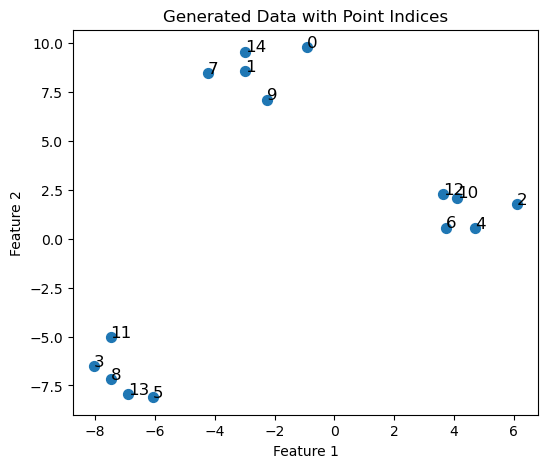

In [23]:
# 人工データの生成
X, y_true = make_blobs(n_samples=15, centers=3, cluster_std=1.0, random_state=42)

# データをプロット
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], s=50)
for i, (x, y) in enumerate(X):
    plt.text(x, y, str(i), fontsize=12)
plt.title("Generated Data with Point Indices")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### 4.2 ウォード法の実装

ウォード法における2つのクラスタ $C_i, C_j$ を併合した際のWCSSの増加量は、以下の式で効率的に計算できます。

$$
\Delta \text{WCSS}(C_i, C_j) = \frac{n_i n_j}{n_i + n_j} ||\boldsymbol{\mu}_i - \boldsymbol{\mu}_j||^2
$$

ここで、$n_i, n_j$ は各クラスタのデータポイント数、$\boldsymbol{\mu}_i, \boldsymbol{\mu}_j$ は各クラスタの重心です。この値を全てのクラスタペアについて計算し、最小となるペアを併合していきます。

In [24]:
def ward_distance(cluster1, cluster2):
    '''ウォード法に基づき，2つのクラスタを併合した際のWCSSの増加量を計算'''
    n1 = cluster1['n_points']
    n2 = cluster2['n_points']
    mu1 = cluster1['centroid']
    mu2 = cluster2['centroid']

    # WCSSの増加量を計算（SciPyと同じ形式にするため平方根を取る）
    distance = np.sqrt((n1*n2) / (n1+n2) * np.sum((mu1 - mu2) ** 2))
    return distance

def agglomerative_clustering(x, n_clusters=None):
    '''ウォード法を用いた凝集型クラスタリング'''
    n_points = len(x)
    
    # 初期化：各データポイントを個別のクラスタとして扱う
    current_clusters = []
    for i in range(n_points):
        cluster = {
            'centroid': x[i], 
            'n_points': 1, 
            'indices': [i],
            'id': i  # 初期IDは0からn_points-1
        }
        current_clusters.append(cluster)

    # 併合の履歴を記録するリスト
    linkage_matrix = []
    next_cluster_id = n_points  # 新しいクラスタのIDは n_points から開始

    # クラスタが1つになるまでループ
    while len(current_clusters) > 1:
        min_dist = float('inf')
        merge_pair = (-1, -1)

        # すべてのクラスタペア間の距離を計算
        for i in range(len(current_clusters)):
            for j in range(i+1, len(current_clusters)):
                dist = ward_distance(current_clusters[i], current_clusters[j])

                if dist < min_dist:
                    min_dist = dist
                    merge_pair = (i, j)

        # 最小距離のクラスタを併合
        i, j = merge_pair
        cluster1 = current_clusters[i]
        cluster2 = current_clusters[j]
        
        # 新しいクラスタの情報を計算
        n1, n2 = cluster1['n_points'], cluster2['n_points']
        new_n_points = n1 + n2
        new_centroid = (n1 * cluster1['centroid'] + n2 * cluster2['centroid']) / new_n_points
        new_indices = cluster1['indices'] + cluster2['indices']
        
        # 併合履歴を記録（SciPyの形式に合わせる）
        linkage_row = [
            float(cluster1['id']), 
            float(cluster2['id']), 
            min_dist, 
            float(new_n_points)
        ]
        linkage_matrix.append(linkage_row)

        # 新しいクラスタを作成
        new_cluster = {
            'centroid': new_centroid, 
            'n_points': new_n_points, 
            'indices': new_indices,
            'id': next_cluster_id
        }
        next_cluster_id += 1

        # 古いクラスタを削除し、新しいクラスタを追加
        # インデックスの大きい方から削除して、インデックスのずれを防ぐ
        current_clusters.pop(max(i, j))
        current_clusters.pop(min(i, j))
        current_clusters.append(new_cluster)

    return np.array(linkage_matrix)

In [25]:
# スクラッチ実装を実行
Z_scratch = agglomerative_clustering(X)

print("Scratch Implementation Linkage Matrix (first 5 rows):")
print(Z_scratch[:5])

Scratch Implementation Linkage Matrix (first 5 rows):
[[10.         12.          0.36109891  2.        ]
 [ 5.         13.          0.60231999  2.        ]
 [ 3.          8.          0.61167895  2.        ]
 [ 4.          6.          0.68987576  2.        ]
 [ 1.         14.          0.71298142  2.        ]]


## 5. デンドログラムによる可視化

階層的クラスタリングの結果は、**デンドログラム（樹形図）**で可視化するのが一般的です。デンドログラムは、クラスタがどの順序で、どの「距離」で併合されたかを示します。

`scipy.cluster.hierarchy.dendrogram` を使って、先ほどスクラッチ実装で得られたリンケージ行列を可視化してみましょう。比較のため、SciPyに組み込まれているウォード法の結果も表示します。

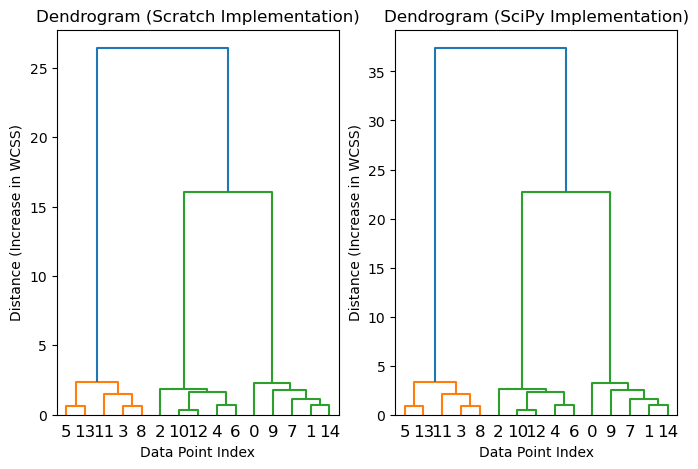

In [27]:
# SciPyのウォード法でリンケージ行列を計算（比較用）
Z_scipy = linkage(X, method='ward')

# デンドログラムの描画
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# スクラッチ実装の結果をプロット
axes[0].set_title('Dendrogram (Scratch Implementation)')
axes[0].set_xlabel('Data Point Index')
axes[0].set_ylabel('Distance (Increase in WCSS)')
dendrogram(Z_scratch, ax=axes[0])

# SciPyの結果をプロット
axes[1].set_title('Dendrogram (SciPy Implementation)')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Distance (Increase in WCSS)')
dendrogram(Z_scipy, ax=axes[1])

plt.show()

**デンドログラムの解釈:**
*   **横軸**: 個々のデータポイントまたはクラスタを示します。
*   **縦軸**: クラスタ間の距離（この場合はWCSSの増加量）を示します。縦線の高さが、その併合が行われたときの距離です。
*   **クラスタ数の決定**: デンドログラムを水平に「切る」ことで、任意の数のクラスタを得ることができます。例えば、縦軸の距離が長いところで切ると、そこが自然なクラスタの境界であると解釈できます。上の図では、距離10あたりで切ると3つのクラスタが得られ、これが妥当な分割であると推測できます。

スクラッチ実装とSciPyの実装が同じデンドログラムを生成しており、アルゴリズムが正しく実装されていることが確認できました。

## 6. まとめと考察

このノートブックでは、階層的クラスタリング、特に凝集型アプローチとその代表的な手法であるウォード法について学び、スクラッチ実装を行いました。

*   **階層的クラスタリング**は、データの階層的な構造を明らかにすることができる強力な教師なし学習手法です。
*   **凝集型クラスタリング**は、ボトムアップに最も似ているクラスタを次々と併合していくアプローチです。
*   どのクラスタを併合するかの基準である**リンケージ法**には、単連結、完全連結、ウォード法など様々な種類があり、それぞれ生成されるクラスタの形状が異なります。
*   **ウォード法**は、クラスタ併合による**分散の増加を最小化**することを目的としており、コンパクトでバランスの取れたクラスタを形成する傾向があります。
*   結果は**デンドログラム**で可視化され、これを見ることで適切なクラスタ数を判断する手がかりが得られます。

K-meansが事前にクラスタ数$K$を必要とするのに対し、階層的クラスタリングはその必要がなく、データの構造をより深く洞察できるという利点があります。一方で、計算量がデータ数の2乗以上に比例するため、大規模なデータセットには適用が難しいという欠点もあります。

タスクの目的やデータセットの規模に応じて、K-meansと階層的クラスタリングを適切に使い分けることが重要です。